In [57]:
import numpy as np
import pandas as pd
import statsmodels.api as sm
import matplotlib.pyplot as plt
from scipy.stats import kstest, norm


def calibrate_gbm(df):
    """
    Calibrate a simple GBM from historical data.
    df must have columns: Open, High, Low, Close, with a DateTime index.
    
    Returns dictionary of { 'mu': ..., 'sigma': ... }, daily parameters.
    """
    close_prices = df['Close'].dropna()
    log_returns = np.log(close_prices / close_prices.shift(1)).dropna()
    
    mu = log_returns.mean()
    sigma = log_returns.std()
    
    return {
        'mu': mu,
        'sigma': sigma
    }

def calibrate_jump_diffusion(df, jump_threshold=3.0):
    """
    Calibrate Jump-Diffusion (Merton) using a basic threshold method for jumps.
    Returns dict with daily parameters: mu, sigma, lambda, nu, delta.
    jump_threshold is the factor of std dev above which a return is considered a jump.
    """
    close_prices = df['Close'].dropna()
    log_returns = np.log(close_prices / close_prices.shift(1)).dropna()
    
    mean_ret = log_returns.mean()
    std_ret = log_returns.std()
    
    threshold_value = mean_ret + jump_threshold * std_ret
    negative_threshold_value = mean_ret - jump_threshold * std_ret
    
    jump_indices = log_returns[(log_returns > threshold_value) | 
                               (log_returns < negative_threshold_value)].index
    jump_values = log_returns.loc[jump_indices]
    
    total_days = len(log_returns)
    num_jumps = len(jump_values)
    lam = num_jumps / total_days  # daily jump intensity
    

    if num_jumps > 0:
        nu = jump_values.mean()    # mean of log(1+J) ~ mean(r)
        delta = jump_values.std()  # std of log(1+J)  ~ std(r)
    else:
        nu = 0.0
        delta = 0.0
    
    # Continuous part (excluding jump days)
    non_jumps = log_returns.drop(jump_indices)
    mu_cont = non_jumps.mean()
    sigma_cont = non_jumps.std()
    
    return {
        'mu': mu_cont,
        'sigma': sigma_cont,
        'lambda': lam,
        'nu': nu,
        'delta': delta
    }



def calibrate_heston(df):
    """
    Calibrate Heston model from historical data.
    Ensures positive kappa and theta estimates.
    
    Returns dict with: {'mu', 'kappa', 'theta', 'sigma_v', 'rho', 'v0'}
    """
    close_prices = df['Close'].dropna()
    log_rets = np.log(close_prices / close_prices.shift(1)).dropna()
    
    mu_est = log_rets.mean()
    
    # Proxy for variance: v_t = (log_rets)^2
    v = log_rets**2
    v_next = v.shift(-1).dropna()
    v_curr = v.dropna()
    v_next = v_next.loc[v_curr.index.intersection(v_next.index)]
    
    # Kappa-theta estimation using OLS
    y = v_next - v_curr
    X = -v_curr  
    X = sm.add_constant(X)
    model = sm.OLS(y, X, missing='drop').fit()
    alpha, beta = model.params[0], model.params[1]
    
    # Ensure positive values
    kappa_est = max(-beta, 1e-3)
    theta_est = max(alpha / kappa_est, 1e-8)  # Ensure non-negative theta

    # Estimate sigma_v from residual approach
    res = model.resid
    valid_mask = (v_curr > 0)
    numerator = (res[valid_mask]**2).sum()
    denominator = v_curr[valid_mask].sum()
    sigma_v_est = np.sqrt(numerator / denominator) if denominator > 0 else 0.01
    
    # Rough correlation estimate between dW1 and dW2
    dW1 = log_rets / np.sqrt(v)
    dW2 = res / (sigma_v_est * np.sqrt(v))
    common_index = dW1.dropna().index.intersection(dW2.dropna().index)
    rho_est = np.corrcoef(dW1.loc[common_index], dW2.loc[common_index])[0,1]
    
    v0_est = max(v.iloc[0], 1e-8)  # Ensure positive v0
    
    return {
        'mu': mu_est,
        'kappa': kappa_est,
        'theta': theta_est,
        'sigma_v': sigma_v_est,
        'rho': rho_est,
        'v0': v0_est
    }


def calibrate_bates(df):
    """
    Bates Model = Heston + Jump-Diffusion.
    Ensures kappa, theta > 0 and lambda detection threshold.
    
    Returns dict: {'mu', 'kappa', 'theta', 'sigma_v', 'rho', 'v0', 'lambda', 'nu', 'delta'}
    """
    heston_params = calibrate_heston(df)
    jd_params = calibrate_jump_diffusion(df, jump_threshold=3.0)
    
    # Ensure lambda is meaningful
    lam = jd_params['lambda']
    if lam < 1e-4:  # If lambda is too small, ignore jumps
        lam = 0.0
        nu = 0.0
        delta = 0.0
    else:
        nu = jd_params['nu']
        delta = jd_params['delta']
    
    bates_params = {
        'mu': heston_params['mu'],
        'kappa': heston_params['kappa'],
        'theta': heston_params['theta'],
        'sigma_v': heston_params['sigma_v'],
        'rho': heston_params['rho'],
        'v0': heston_params['v0'],
        'lambda': lam,
        'nu': nu,
        'delta': delta
    }
    
    return bates_params

###############################################################################


def simulate_gbm(params, S0, n_days, dt=1/252, seed=42):
    """
    Simulate daily closes from a calibrated GBM model.
    params: {'mu':..., 'sigma':...} in daily terms
    """
    np.random.seed(seed)
    mu, sigma = params['mu'], params['sigma']
    S = np.zeros(n_days+1)
    S[0] = S0
    
    for t in range(1, n_days+1):
        z = np.random.normal()
        S[t] = S[t-1] * np.exp((mu - 0.5*sigma**2)*dt + sigma*np.sqrt(dt)*z)
    return S

def simulate_gbm_paths(params, S0, n_days, n_sims = 1, dt=1/252, seed=42):
    """
    Simulate multiple paths from a Geometric Brownian Motion (GBM) model.
    params: {'mu':..., 'sigma':...} in daily terms
    S0: Initial stock price
    n_days: Number of days to simulate
    n_sims: Number of simulation paths
    """
    np.random.seed(seed)
    mu, sigma = params['mu'], params['sigma']
    
    S = np.zeros((n_days + 1, n_sims))
    S[0] = S0
    
    for t in range(1, n_days + 1):
        z = np.random.normal(size=n_sims)
        S[t] = S[t-1] * np.exp((mu - 0.5 * sigma**2) * dt + sigma * np.sqrt(dt) * z)
    
    return S

def simulate_jump_diffusion(params, S0, n_days, dt=1/252, seed=42):
    """
    Simulates the Merton Jump-Diffusion process using Poisson-distributed jumps.
    params: Dictionary {'mu','sigma','lambda','nu','delta'} (daily values)
    S0: Initial stock price
    n_days: Number of days to simulate
    dt: Time step (default assumes daily steps)
    """
    np.random.seed(seed)
    mu, sigma = params['mu'], params['sigma']
    lam, nu, delta = params['lambda'], params['nu'], params['delta']
    
    S = np.zeros(n_days + 1)
    S[0] = S0
    
    for t in range(1, n_days + 1):

        z = np.random.normal()
        cont_part = np.exp((mu - 0.5 * sigma**2) * dt + sigma * np.sqrt(dt) * z)
        
        N = np.random.poisson(lam * dt)  
        
        if N > 0:
            J = np.prod(np.exp(nu + delta * np.random.normal(size=N)) - 1 + 1)  # Product of multiple jumps
        else:
            J = 1
        
        S[t] = S[t - 1] * cont_part * J
    
    return S

def simulate_jump_diffusion_paths(params, S0, n_days, n_sims = 1, dt=1/252, seed=42):
    """
    Simulates multiple paths of the Merton Jump-Diffusion model.
    params: {'mu','sigma','lambda','nu','delta'} (daily values)
    S0: Initial stock price
    n_days: Number of days to simulate
    n_sims: Number of simulation paths
    """
    np.random.seed(seed)
    mu, sigma = params['mu'], params['sigma']
    lam, nu, delta = params['lambda'], params['nu'], params['delta']
    
    S = np.zeros((n_days + 1, n_sims))
    S[0] = S0
    
    for t in range(1, n_days + 1):
        z = np.random.normal(size=n_sims)
        cont_part = np.exp((mu - 0.5 * sigma**2) * dt + sigma * np.sqrt(dt) * z)
        
        N = np.random.poisson(lam * dt, size=n_sims)
        J = np.exp(nu + delta * np.random.normal(size=n_sims)) - 1
        jump_part = np.where(N > 0, (1 + J)**N, 1)
        
        S[t] = S[t-1] * cont_part * jump_part
    
    return S


def simulate_heston(params, S0, n_days, dt=1/252, seed=42):
    """
    Heston daily closes (Euler discretization).
    params: {'mu','kappa','theta','sigma_v','rho','v0'}
    S0: initial price
    """
    np.random.seed(seed)
    mu = params['mu']
    kappa, theta, sigma_v, rho, v0 = params['kappa'], params['theta'], params['sigma_v'], params['rho'], params['v0']
    
    S = np.zeros(n_days + 1)
    v = np.zeros(n_days + 1)
    S[0] = S0
    v[0] = v0
    
    for t in range(1, n_days + 1):
        z1 = np.random.normal()
        z2 = np.random.normal()
        
        w1 = z1
        w2 = rho * z1 + np.sqrt(1 - rho**2) * z2
        
        v_prev = max(v[t-1], 1e-8)
        dv = kappa * (theta - v_prev) * dt + sigma_v * np.sqrt(v_prev) * np.sqrt(dt) * w2
        v_new = max(v_prev + dv, 1e-8)  # Keep variance positive
        
        S_prev = S[t-1]
        S_new = S_prev * np.exp((mu - 0.5 * v_prev) * dt + np.sqrt(v_prev) * np.sqrt(dt) * w1)
        
        # Store values
        S[t] = max(S_new, 1e-8)
        v[t] = v_new
    
    return S

def simulate_heston_paths(params, S0, n_days, n_sims = 1, dt=1/252, seed=42):
    """
    Simulates multiple paths using the Heston stochastic volatility model.
    params: {'mu','kappa','theta','sigma_v','rho','v0'}
    S0: Initial stock price
    n_days: Number of days to simulate
    n_sims: Number of simulation paths
    """
    np.random.seed(seed)
    mu, kappa, theta, sigma_v, rho, v0 = params['mu'], params['kappa'], params['theta'], params['sigma_v'], params['rho'], params['v0']
    
    S = np.zeros((n_days + 1, n_sims))
    v = np.zeros((n_days + 1, n_sims))
    S[0] = S0
    v[0] = v0
    
    for t in range(1, n_days + 1):
        z1, z2 = np.random.normal(size=n_sims), np.random.normal(size=n_sims)
        w1 = z1
        w2 = rho * z1 + np.sqrt(1 - rho**2) * z2
        
        v_prev = np.maximum(v[t-1], 1e-8)
        dv = kappa * (theta - v_prev) * dt + sigma_v * np.sqrt(v_prev) * np.sqrt(dt) * w2
        v_new = np.maximum(v_prev + dv, 1e-8)
        
        S_prev = S[t-1]
        S_new = S_prev * np.exp((mu - 0.5 * v_prev) * dt + np.sqrt(v_prev) * np.sqrt(dt) * w1)
        
        S[t] = np.maximum(S_new, 1e-8)
        v[t] = v_new
    
    return S


def simulate_bates(params, S0, n_days, dt=1/252, seed=42):
    """
    Bates Model = Heston Stochastic Volatility + Poisson Jump Process.
    Uses Euler discretization for variance and price updates.
    
    params: {'mu', 'kappa', 'theta', 'sigma_v', 'rho', 'v0', 'lambda', 'nu', 'delta'}
    S0: Initial stock price
    n_days: Number of trading days to simulate
    dt: Time step size (default = daily steps)
    """
    np.random.seed(seed)
    
    mu, kappa, theta = params['mu'], params['kappa'], params['theta']
    sigma_v, rho, v0 = params['sigma_v'], params['rho'], params['v0']
    lam, nu, delta = params['lambda'], params['nu'], params['delta']
    
    S = np.zeros(n_days + 1)
    v = np.zeros(n_days + 1)
    S[0] = S0
    v[0] = v0
    
    for t in range(1, n_days + 1):
        z1, z2 = np.random.normal(), np.random.normal()
        w1 = z1
        w2 = rho * z1 + np.sqrt(1 - rho**2) * z2
        
        v_prev = max(v[t-1], 1e-8)  # Ensure variance remains positive
        dv = kappa * (theta - v_prev) * dt + sigma_v * np.sqrt(v_prev) * np.sqrt(dt) * w2
        v_new = max(v_prev + dv, 1e-8)  # Prevent negative variance
        
        S_prev = S[t-1]
        S_cont = S_prev * np.exp((mu - 0.5 * v_prev) * dt + np.sqrt(v_prev) * np.sqrt(dt) * w1)
        
        N = np.random.poisson(lam * dt)  
        if N > 0:
            J = np.prod(np.exp(nu + delta * np.random.normal(size=N)) - 1 + 1)  
        else:
            J = 1 
        
        S[t] = max(S_cont * J, 1e-8)  # Prevent negative prices
        v[t] = v_new  
    
    return S

def simulate_bates_paths(params, S0, n_days, n_sims = 1, dt=1/252, seed=42):
    """
    Bates Model = Heston Stochastic Volatility + Poisson Jump Process.
    Uses Euler discretization for variance and price updates.
    
    params: {'mu', 'kappa', 'theta', 'sigma_v', 'rho', 'v0', 'lambda', 'nu', 'delta'}
    S0: Initial stock price
    n_days: Number of trading days to simulate
    n_sims: Number of paths to simulate
    dt: Time step size (default = daily steps)
    """
    np.random.seed(seed)
    
    mu, kappa, theta = params['mu'], params['kappa'], params['theta']
    sigma_v, rho, v0 = params['sigma_v'], params['rho'], params['v0']
    lam, nu, delta = params['lambda'], params['nu'], params['delta']
    
    S = np.zeros((n_days + 1, n_sims))
    v = np.zeros((n_days + 1, n_sims))
    S[0] = S0
    v[0] = v0
    
    for t in range(1, n_days + 1):
        z1, z2 = np.random.normal(size=n_sims), np.random.normal(size=n_sims)
        w1 = z1
        w2 = rho * z1 + np.sqrt(1 - rho**2) * z2
        
        v_prev = np.maximum(v[t-1], 1e-8)
        dv = kappa * (theta - v_prev) * dt + sigma_v * np.sqrt(v_prev) * np.sqrt(dt) * w2
        v_new = np.maximum(v_prev + dv, 1e-8)
        
        S_prev = S[t-1]
        S_cont = S_prev * np.exp((mu - 0.5 * v_prev) * dt + np.sqrt(v_prev) * np.sqrt(dt) * w1)
        
        N = np.random.poisson(lam * dt, size=n_sims)
        J = np.exp(nu + delta * np.random.normal(size=n_sims)) - 1
        jump_part = np.where(N > 0, (1 + J)**N, 1)
        
        S[t] = np.maximum(S_cont * jump_part, 1e-8)
        v[t] = v_new
    
    return S



###############################################################################
#    PART 3: BACKTEST THE ACCURACY OF HISTORICAL FIT (SIMPLE K-S COMPARISON)
###############################################################################
def backtest_historical_fit(df, simulated_prices):
    """
    Compare the distribution of historical log returns vs. simulated log returns 
    using a K-S test.
    df: historical data (with 'Close')
    simulated_prices: array-like or series of simulated closes (same length or can be large).
    
    Returns (ks_stat, ks_pvalue).
    """
    hist_close = df['Close'].dropna()
    hist_logr = np.log(hist_close / hist_close.shift(1)).dropna()
    
    sim_close = pd.Series(simulated_prices)
    sim_logr = np.log(sim_close / sim_close.shift(1)).dropna()
    
    ks_stat, ks_pvalue = kstest(hist_logr, sim_logr)
    return ks_stat, ks_pvalue


def backtest_historical_fit_paths(df, simulated_prices_matrix):
    """
    Compare the distribution of historical log returns vs. simulated log returns 
    using a Kolmogorov-Smirnov (K-S) test.
    
    df: DataFrame with historical 'Close' prices.
    simulated_prices_matrix: 2D array (n_days+1, n_sims) of simulated prices.
    
    Returns:
    - KS Statistic
    - KS p-value
    """
    hist_close = df['Close'].dropna()
    hist_logr = np.log(hist_close / hist_close.shift(1)).dropna()
    
    sim_logr = np.log(simulated_prices_matrix[1:] / simulated_prices_matrix[:-1])
    sim_logr_flat = sim_logr.flatten()  

    ks_stat, ks_pvalue = kstest(hist_logr, sim_logr_flat)
    
    return ks_stat, ks_pvalue


###############################################################################
#     PART 4: BROWNIAN BRIDGE TO GET DAILY HIGH/LOW FROM SIMULATED CLOSES
###############################################################################
def estimate_intraday_sigma(params, model_type="GBM", steps_per_day=24):
    """
    Estimate intraday volatility sigma for the Brownian Bridge based on model parameters.
    
    params: Dictionary of model parameters.
    model_type: One of ["GBM", "Jump-Diffusion", "Heston", "Bates"]
    steps_per_day: Number of intraday time steps (default: 24 steps = 1 hour intervals)
    
    Returns: Estimated sigma_intraday
    """
    if model_type == "GBM":
        sigma_daily = params["sigma"]
    
    elif model_type == "Jump-Diffusion":
        sigma = params["sigma"]
        lam = params["lambda"]
        nu = params["nu"]
        delta = params["delta"]
        sigma_daily = np.sqrt(sigma**2 + lam * (nu**2 + delta**2))
    
    elif model_type == "Heston":
        theta = params["theta"]
        sigma_daily = np.sqrt(theta)
    
    elif model_type == "Bates":
        theta = params["theta"]
        lam = params["lambda"]
        nu = params["nu"]
        delta = params["delta"]
        sigma_daily = np.sqrt(theta + lam * (nu**2 + delta**2))
    
    else:
        raise ValueError("Invalid model_type. Choose from 'GBM', 'Jump-Diffusion', 'Heston', or 'Bates'.")

    # Compute intraday sigma
    sigma_intraday = sigma_daily / np.sqrt(steps_per_day)
    
    return sigma_intraday


def brownian_bridge_daily(sim_closes, steps_per_day=24, seed=42):
    """
    For each day (from sim_closes[t-1] to sim_closes[t]), 
    construct an intraday path (brownian-bridge style) to get the daily High/Low.
    
    Returns a DataFrame with columns: 'Open','High','Low','Close'
    and the same length as len(sim_closes)-1 for each "day".
    """
    np.random.seed(seed)
    n_days = len(sim_closes) - 1
    
    records = []
    
    for i in range(n_days):
        open_price = sim_closes[i]
        close_price = sim_closes[i+1]
        
        # We'll create steps_per_day - 1 intraday points bridging
        path = np.zeros(steps_per_day+1)
        path[0] = open_price
        path[steps_per_day] = close_price
        
        for step in range(1, steps_per_day):
            # naive approach
            # linear interpolation as the drift of the "bridge"
            fraction = step / steps_per_day
            drift = path[step-1] + (close_price - path[step-1]) / (steps_per_day - step + 1)
            
            # random shock scaled by some fraction
            scale = 0.01 * path[step-1]  # can be tuned or linked to volatility
            path[step] = drift + np.random.normal(0, scale)
        
        day_high = path.max()
        day_low = path.min()
        
        records.append({
            'Open': path[0],
            'High': day_high,
            'Low': day_low,
            'Close': path[-1]
        })
    
    df_bridge = pd.DataFrame(records)
    return df_bridge

import numpy as np
import pandas as pd

def brownian_bridge_paths(sim_closes_matrix, steps_per_day=24, sigma_intraday=0.02, seed=42):
    """
    Simulate independent intraday paths using a Brownian Bridge approach.
    
    sim_closes_matrix: (n_days+1, n_sims) matrix of simulated daily close prices.
    steps_per_day: Number of intraday steps for the Brownian bridge.
    sigma_intraday: Estimated intraday volatility.
    
    Returns:
    - A dictionary of DataFrames, one per simulation, with columns: 'Open', 'High', 'Low', 'Close'.
    """
    np.random.seed(seed)
    
    n_days, n_sims = sim_closes_matrix.shape[0] - 1, sim_closes_matrix.shape[1]
    
    # Store DataFrames for each simulation separately
    sim_dataframes = {}

    for sim in range(n_sims):
        open_prices = sim_closes_matrix[:-1, sim]
        close_prices = sim_closes_matrix[1:, sim]

        high_prices = np.zeros(n_days)
        low_prices = np.zeros(n_days)
        
        for i in range(n_days):
            open_day = open_prices[i]
            close_day = close_prices[i]
            
            # Generate time grid for intraday steps
            t = np.linspace(0, 1, steps_per_day+1)
            
            # Brownian bridge formula: drift + volatility term
            drift = (1 - t) * open_day + t * close_day
            volatility = sigma_intraday * np.sqrt(t * (1 - t)) * np.random.randn(steps_per_day+1)

            bridge_path = drift + volatility
            
            # Store intraday high/low for the day
            high_prices[i] = bridge_path.max()
            low_prices[i] = bridge_path.min()

        # Create a DataFrame for this simulation
        df_bridge = pd.DataFrame({
            'Open': open_prices,
            'High': high_prices,
            'Low': low_prices,
            'Close': close_prices
        })
        
        sim_dataframes[sim] = df_bridge  # Store each simulation separately
    
    return sim_dataframes


###############################################################################
#  PART 5: BACKTEST TRADER USING TRENDER COLUMNS
###############################################################################

def ewm_std(series, span):
    ewm_mean   = series.ewm(span=span, adjust=False).mean()
    ewm_meansq = (series**2).ewm(span=span, adjust=False).mean()
    return np.sqrt(ewm_meansq - ewm_mean**2)

def trender_bloomberg_style(df, period=14, sensitivity=1, use_close=True):

    df = df.copy()
    df.sort_index(inplace=True)

    high = df['High']
    low  = df['Low']
    close = df['Close']

    prev_close = close.shift(1)
    tr = pd.DataFrame({
        'r1': high - low,
        'r2': (high - prev_close).abs(),
        'r3': (low  - prev_close).abs()
    }).max(axis=1)

    mp = 0.5*(high + low)

    ema_mp = mp.ewm(span=period, adjust=False).mean()
    ema_tr = tr.ewm(span=period, adjust=False).mean()

    sd_ema_tr = ewm_std(ema_tr, period)

    up_base   = ema_mp - 0.5*ema_tr - sensitivity*sd_ema_tr
    down_base = ema_mp + 0.5*ema_tr + sensitivity*sd_ema_tr

    n = len(df)
    up_line   = np.full(n, np.nan)
    down_line = np.full(n, np.nan)
    trend     = np.full(n, 0, dtype=int)

    # pick an initial day where stdev is not NaN
    first_valid = sd_ema_tr.first_valid_index()
    if first_valid is None:
        return pd.DataFrame(
            {'TrenderUp': up_line, 'TrenderDown': down_line, 'Trend': trend},
            index=df.index
        )
    start_i = df.index.get_loc(first_valid)

    # initial condition
    # e.g. if close > up_base => uptrend
    price_series = close if use_close else high
    if price_series.iloc[start_i] > up_base.iloc[start_i]:
        trend[start_i] = +1
        up_line[start_i] = up_base.iloc[start_i]
    else:
        trend[start_i] = -1
        down_line[start_i] = down_base.iloc[start_i]


    for i in range(start_i, n-1):
        if trend[i] == +1:

            if i > start_i:
                up_line[i] = max(up_base[i], up_line[i-1])
            if price_series.iloc[i] < up_line[i]:
                trend[i+1] = -1
            else:
                trend[i+1] = +1
        else:
            if i > start_i:
                down_line[i] = min(down_base[i], down_line[i-1])
            if price_series.iloc[i] > down_line[i]:
                trend[i+1] = +1
            else:
                trend[i+1] = -1

    if trend[n-1] == +1:
        up_line[n-1] = max(up_base.iloc[n-1], up_line[n-2])
    else:
        down_line[n-1] = min(down_base.iloc[n-1], down_line[n-2])

    for i in range(n):
        if trend[i] == +1:
            down_line[i] = np.nan
        else:
            up_line[i] = np.nan

    return pd.DataFrame({
        'TrenderUp': up_line,
        'TrenderDown': down_line,
        'Trend': trend
    }, index=df.index)


def backtest_trender_strategy(df, initial_capital=100000.0, mode='long_only', 
                              annual_factor=252):
    """
    df must have columns: 'Close', 'TrenderDown', 'TrenderUp'.
    Strategy:
      - 'long_only':
          * Enter/hold a long position if Close > TrenderDown
          * Exit to cash if Close < TrenderUp
      - 'long_short':
          * Long if Close > TrenderDown
          * Short if Close < TrenderUp (0 or negative position)
    
    Returns a dictionary of performance metrics:
      - annual_vol, mean_return, max_drawdown, max_drawdown_duration,
        num_trades, win_ratio, sharpe_ratio, etc.
    """
    # We'll track a position in units of "shares" or "notional"? 
    # For simplicity, let's do notional approach:
    # position = 1 => fully invested long with all capital
    # position = -1 => fully short with all capital
    # position = 0 => no position.
    
    closes = df['Close'].values
    trender_down = df['TrenderDown'].values
    trender_up = df['TrenderUp'].values
    n = len(df)
    
    position = 0  # start flat
    capital = initial_capital
    equity_curve = np.zeros(n)
    
    # For performance metrics
    trades = []
    last_trade_price = None
    last_position = 0
    
    for i in range(n):
        price = closes[i]
        if i == 0:
            equity_curve[i] = capital
            continue
        
        # Check signals
        if mode == 'long_only':
            if position <= 0:
                # Check if we should go long
                if price > trender_down[i]:
                    # open a long
                    position = 1
                    last_trade_price = price
                    trades.append({'side':'buy','price':price})
            else:
                # we are long, check exit
                if price < trender_up[i]:
                    # close long
                    position = 0
                    # record trade
                    trades.append({'side':'sell','price':price})
                    
        elif mode == 'long_short':
            if position <= 0:
                # we are short or flat
                if price > trender_down[i]:
                    # go long
                    position = 1
                    trades.append({'side':'buy','price':price})
            if position >= 0:
                # we are long or flat
                if price < trender_up[i]:
                    # go short
                    position = -1
                    trades.append({'side':'short','price':price})
        
        # Update equity via daily mark-to-market
        # We'll assume if position=1, our equity changes by daily % change from prev day
        # If position=-1, we profit if price goes down
        # This is a simplified model ignoring leverage constraints, etc.
        
        price_prev = closes[i-1]
        daily_ret = (price - price_prev) / price_prev
        
        if position == 1:
            capital *= (1 + daily_ret)
        elif position == -1:
            capital *= (1 - daily_ret)
        
        equity_curve[i] = capital
    
    # Compute performance metrics
    # 1) final return
    total_return = (equity_curve[-1] / equity_curve[0]) - 1.0
    # 2) daily returns from equity curve
    eq_daily_ret = pd.Series(np.diff(equity_curve)/equity_curve[:-1])
    mean_daily_ret = eq_daily_ret.mean()
    std_daily_ret = eq_daily_ret.std()
    annual_vol = std_daily_ret * np.sqrt(annual_factor)
    annual_return = (1 + mean_daily_ret)**annual_factor - 1
    # Sharpe
    if annual_vol != 0:
        sharpe_ratio = (annual_return - 0.0) / annual_vol  # risk-free ~0
    else:
        sharpe_ratio = np.nan
    
    # Max drawdown & duration
    # Running peak
    running_max = np.maximum.accumulate(equity_curve)
    drawdowns = (equity_curve - running_max) / running_max
    max_dd = drawdowns.min()
    max_dd_idx = drawdowns.argmin()
    
    # max drawdown duration: length from previous peak to recovery
    # quick method: track from point of the drawdown until equity re-hits that peak
    dd_durations = []
    peak_idx = 0
    for i in range(1, n):
        if equity_curve[i] > running_max[i-1]:
            # reset peak
            peak_idx = i
        dd_durations.append(i - peak_idx)
    max_dd_duration = max(dd_durations) if dd_durations else 0
    
    # number of trades
    num_trades = len(trades)
    # win ratio
    # We'll treat each pair (buy->sell) or (short->cover) as one trade
    # For simplicity, we approximate:
    realized_pnl = []
    pos_side = None
    entry_price = None
    for trd in trades:
        if trd['side'] in ['buy','short']:
            pos_side = trd['side']
            entry_price = trd['price']
        elif trd['side'] == 'sell' and pos_side=='buy':
            # close a long
            exit_price = trd['price']
            realized_pnl.append(exit_price - entry_price)
            pos_side = None
        elif trd['side'] == 'short' and pos_side=='short':
            # short again? This logic can get complicated for "long_short"
            pass
        elif trd['side'] == 'short' and pos_side=='buy':
            # reversing from long to short
            exit_price = trd['price']
            realized_pnl.append(exit_price - entry_price)
            pos_side = 'short'
            entry_price = exit_price
        elif trd['side'] in ['sell'] and pos_side=='short':
            # close short
            exit_price = trd['price']
            realized_pnl.append(entry_price - exit_price)
            pos_side = None
    
    if len(realized_pnl) > 0:
        wins = sum([1 for x in realized_pnl if x>0])
        losses = sum([1 for x in realized_pnl if x<=0])
        win_ratio = wins / (wins+losses)
    else:
        win_ratio = np.nan
    
    results = {
        'final_equity': equity_curve[-1],
        'total_return': total_return,
        'annual_return': annual_return,
        'annual_vol': annual_vol,
        'sharpe_ratio': sharpe_ratio,
        'max_drawdown': max_dd,  # typically negative
        'max_drawdown_duration': max_dd_duration,
        'num_trades': num_trades,
        'win_ratio': win_ratio
    }
    
    return results, pd.Series(equity_curve, index=df.index)

def apply_trender_to_simulations(simulated_prices):
    """
    Apply the Trender indicator to multiple simulated price paths.
    
    simulated_prices: dict of DataFrames containing 'Open', 'High', 'Low', 'Close' for each simulation.
    
    Returns:
    - dict of DataFrames containing 'TrenderUp', 'TrenderDown', 'Trend' for each simulation.
    """
    trender_results = {}
    
    for sim_id, df in simulated_prices.items():
        trender_results[sim_id] = trender_bloomberg_style(df)
    
    return trender_results

def backtest_trender_multiple_paths(simulated_prices, trender_results, mode='long_only', initial_capital=100000.0):
    """
    Backtest the Trender strategy across multiple simulated price paths.
    
    Parameters:
    - simulated_prices: dict of simulated OHLC price DataFrames.
    - trender_results: dict of Trender indicators for each simulation.
    - mode: 'long_only' or 'long_short'.
    - initial_capital: Starting capital for backtest.
    
    Returns:
    - Dictionary of performance metrics aggregated across all paths.
    - Dictionary of equity curves for each path.
    """
    performance_metrics = []
    equity_curves = {}

    for sim_id in simulated_prices.keys():
        df = simulated_prices[sim_id].copy()
        df[['TrenderUp', 'TrenderDown', 'Trend']] = trender_results[sim_id]

        # Backtest strategy
        results, equity_curve = backtest_trender_strategy(df, initial_capital, mode)
        
        performance_metrics.append(results)
        equity_curves[sim_id] = equity_curve

    # Convert results into a DataFrame
    df_results = pd.DataFrame(performance_metrics)

    # Aggregate results
    aggregated_results = {
        "mean": df_results.mean(),
        "std": df_results.std(),
        "min": df_results.min(),
        "max": df_results.max(),
    }

    return aggregated_results, df_results, equity_curves

def select_best_model(backtest_results):
    """
    Selects the best model based on KS-statistic.
    If all p-values are 0, selects the model with the lowest KS-stat.
    Prefers more complex models (Bates > Heston > Jump-Diffusion > GBM).
    """
    # Sort models by KS statistic (lower is better)
    ranked_models = backtest_results.T.sort_values(by="KS_Stat")
    
    # Select the model with the lowest KS-Stat
    best_model = ranked_models.index[0]
    
    # Ensure we prioritize more advanced models if KS stats are close
    if best_model == "GBM" and ranked_models.iloc[1]["KS_Stat"] < ranked_models.iloc[0]["KS_Stat"] * 1.05:
        best_model = ranked_models.index[1]  # Prefer Jump-Diffusion
    if best_model in ["GBM", "Jump-Diffusion"] and ranked_models.iloc[2]["KS_Stat"] < ranked_models.iloc[0]["KS_Stat"] * 1.05:
        best_model = ranked_models.index[2]  # Prefer Heston
    if best_model in ["GBM", "Jump-Diffusion", "Heston"] and ranked_models.iloc[3]["KS_Stat"] < ranked_models.iloc[0]["KS_Stat"] * 1.05:
        best_model = ranked_models.index[3]  # Prefer Bates

    return best_model




In [39]:
path = "Data/Historical_prices.xlsx"
df = pd.read_excel(path, sheet_name="data", header=[0, 1], index_col=0, parse_dates=True, skiprows=[2])
Gold_dataframe = df.loc[:, pd.IndexSlice["XAU Curncy", :]]
Gold_dataframe.columns = Gold_dataframe.columns.droplevel(0)
Gold_dataframe.columns = ["Close", "High", "Low", "Open"]


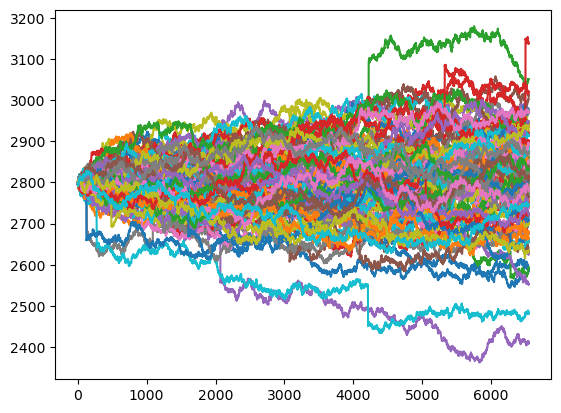

In [55]:
# plt.plot(Gold_dataframe["Close"])
plt.plot(jd_paths)

In [101]:
bates_params

{'mu': 0.0003469407074596697,
 'kappa': 0.001,
 'theta': 0.09824130899728414,
 'sigma_v': 0.02957335902657991,
 'rho': 0.014049328782394071,
 'v0': 0.0005585416171523473,
 'lambda': 0.013753056234718826,
 'nu': -0.01168310183391883,
 'delta': 0.04224064048665938}

In [94]:
df_hist = Gold_dataframe.copy()

# Step 2: Calibrate Models
gbm_params = calibrate_gbm(df_hist)
jd_params = calibrate_jump_diffusion(df_hist)
heston_params = calibrate_heston(df_hist)
bates_params = calibrate_bates(df_hist)

# Step 3: Simulate Synthetic Prices
n_days = len(df_hist)
n_sims = 100
S0 = df_hist['Close'].iloc[-1]

gbm_paths = simulate_gbm_paths(gbm_params, S0, n_days, n_sims)
jd_paths = simulate_jump_diffusion_paths(jd_params, S0, n_days, n_sims)
heston_paths = simulate_heston_paths(heston_params, S0, n_days, n_sims)
bates_paths = simulate_bates_paths(bates_params, S0, n_days, n_sims)

# Step 4: Determine the Best Model Based on KS-Test
ks_gbm = backtest_historical_fit_paths(df_hist, gbm_paths)
ks_jd = backtest_historical_fit_paths(df_hist, jd_paths)
ks_heston = backtest_historical_fit_paths(df_hist, heston_paths)
ks_bates = backtest_historical_fit_paths(df_hist, bates_paths)

backtest_results = pd.DataFrame({
    "GBM": ks_gbm[:2],
    "Jump-Diffusion": ks_jd[:2],
    "Heston": ks_heston[:2],
    "Bates": ks_bates[:2]
}, index=["KS_Stat", "P-Value"])

display(backtest_results)

# Step 5: Use the Best Model
best_model = select_best_model(backtest_results)
print(f"Best Model Selected: {best_model}")

if best_model == "GBM":
    synthetic_prices = gbm_paths
elif best_model == "Jump-Diffusion":
    synthetic_prices = jd_paths
elif best_model == "Heston":
    synthetic_prices = heston_paths
else:
    synthetic_prices = bates_paths

# Step 6: Generate Intraday OHLC Using Brownian Bridge
sigma_intraday = estimate_intraday_sigma(eval(f"{best_model.lower()}_params"), model_type=best_model, steps_per_day=48)
intraday_prices = brownian_bridge_paths(synthetic_prices, steps_per_day=48, sigma_intraday=sigma_intraday)

# Step 7: Apply Trender Indicator
trender_results = apply_trender_to_simulations(intraday_prices)

# Step 8: Backtest Trender Strategy Across Paths
aggregated_results, individual_results, equity_curves = backtest_trender_multiple_paths(
    intraday_prices, trender_results, mode='long_only', initial_capital=100000.0
)

# Step 9: Display Backtest Results
display(pd.DataFrame(aggregated_results).style.format("{:.2%}"))

# Step 10: Display Sample Equity Curve
display(equity_curves[0])


C:\Users\josel\AppData\Local\Temp\ipykernel_9664\2220834309.py:95: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  alpha, beta = model.params[0], model.params[1]
C:\Users\josel\AppData\Local\Temp\ipykernel_9664\2220834309.py:95: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  alpha, beta = model.params[0], model.params[1]


,GBM,Jump-Diffusion,Heston,Bates
KS_Stat,0.433984,0.443522,0.307413,0.291627
P-Value,0.000000,0.000000,0.000000,0.000000


Best Model Selected: Bates


,mean,std,min,max
final_equity,572204466.97%,2456862797.54%,14073139.59%,17847302138.57%
total_return,5622.04%,24568.63%,40.73%,178373.02%
annual_return,7.21%,6.70%,1.33%,34.23%
annual_vol,2.81%,2.11%,0.64%,11.03%
sharpe_ratio,239.09%,32.91%,180.01%,319.82%
max_drawdown,-1.66%,0.98%,-6.24%,-0.44%
max_drawdown_duration,14658.00%,4875.17%,6900.00%,33600.00%
num_trades,58557.00%,3463.61%,50800.00%,66300.00%
win_ratio,29.69%,2.80%,23.87%,36.74%


0       100000.000000
1       100000.000000
2       100000.000000
3       100000.000000
4       100000.000000
            ...      
6540    483342.564176
6541    483342.564176
6542    483342.564176
6543    483342.564176
6544    483342.564176
Length: 6545, dtype: float64

In [62]:
df_hist[['TrenderUp', 'TrenderDown', 'Trend']] = trender_bloomberg_style(df_hist)
results, equity_curve = backtest_trender_strategy(df_hist, initial_capital=100000.0, mode='long_only')

C:\Users\josel\AppData\Local\Temp\ipykernel_9664\2220834309.py:670: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  up_line[i] = max(up_base[i], up_line[i-1])
C:\Users\josel\AppData\Local\Temp\ipykernel_9664\2220834309.py:677: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  down_line[i] = min(down_base[i], down_line[i-1])


<Axes: title={'center': 'Trender Indicator'}>

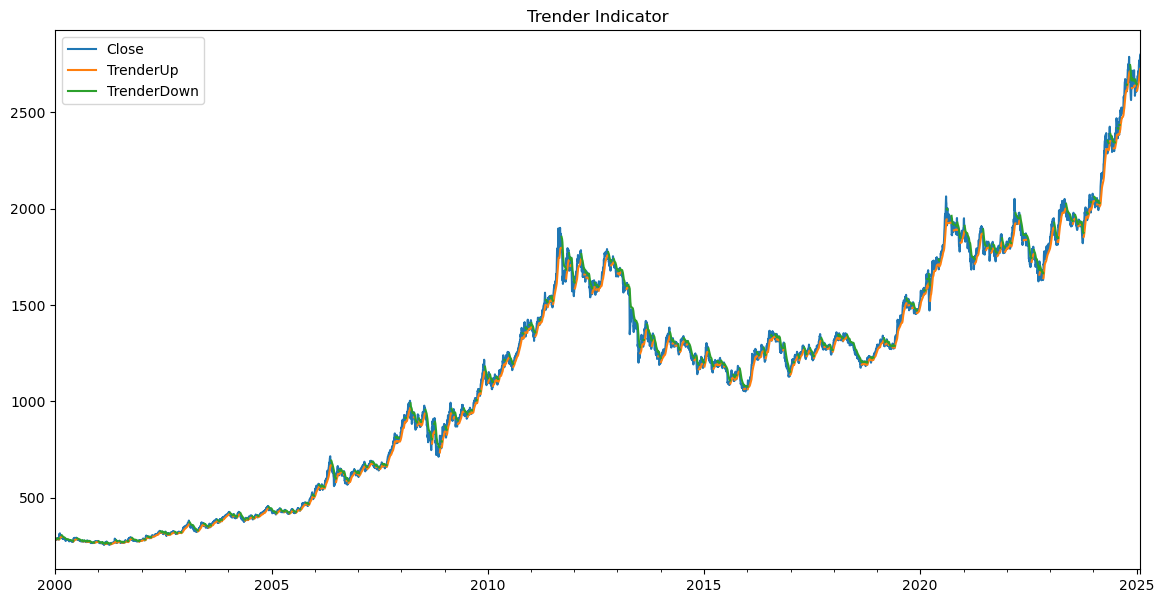

In [74]:
df_hist.loc[df_hist.index >= "2000-01-01",["Close", "TrenderUp", "TrenderDown"]].plot(figsize=(14, 7), title="Trender Indicator")

<Axes: title={'center': 'Trender Indicator'}>

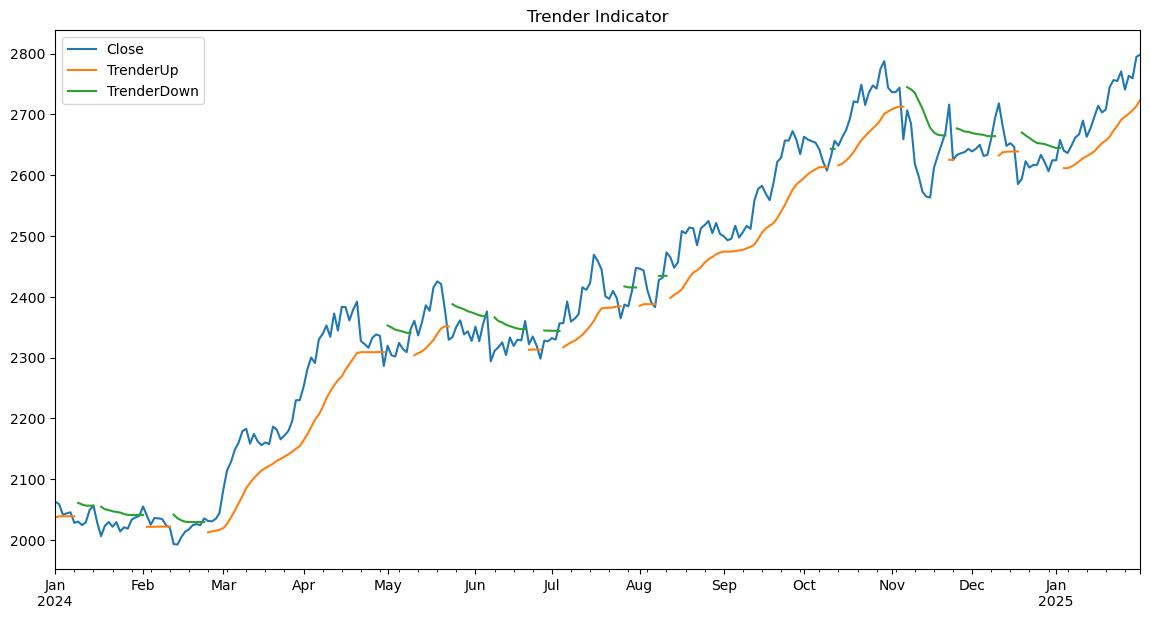

In [73]:
df_hist.loc[df_hist.index >= "2024-01-01",["Close", "TrenderUp", "TrenderDown"]].plot(figsize=(14, 7), title="Trender Indicator")

In [89]:
simulation_results = intraday_prices[12].copy()
simulation_results

,Open,High,Low,Close
0,2798.410000,2799.418994,2798.410000,2799.418994
1,2799.418994,2799.418994,2798.941041,2798.941041
2,2798.941041,2798.943644,2798.641760,2798.641760
3,2798.641760,2798.641760,2796.067654,2796.067654
4,2796.067654,2803.025579,2796.067654,2803.025579
...,...,...,...,...
6540,2690.285343,2690.285343,2689.305373,2689.305373
6541,2689.305373,2689.305373,2681.584966,2681.584966
6542,2681.584966,2681.584966,2658.320065,2658.320065
6543,2658.320065,2658.320065,2622.240147,2622.240147


<Axes: title={'center': 'High Low - Simulation'}>

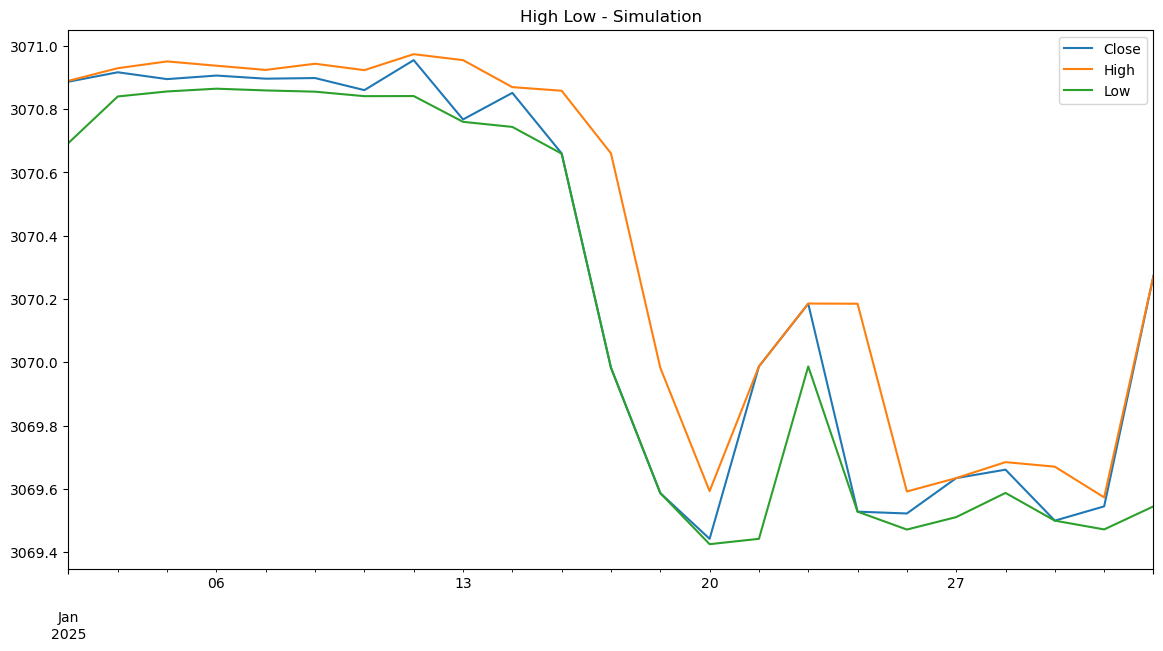

In [98]:
simulation_results = intraday_prices[10].copy()
simulation_results[['TrenderUp', 'TrenderDown', 'Trend']]  = trender_results[10].copy()
simulation_results.index = df_hist.index
simulation_results.loc[simulation_results.index >= "2025-01-01",["Close", "High", "Low"]].plot(figsize=(14, 7), title="High Low - Simulation")

In [67]:
pd.DataFrame(results, index=[0]).T.style.format("{:.2f}")

,0
final_equity,161315231.13
total_return,1612.15
annual_return,0.34
annual_vol,0.12
sharpe_ratio,2.78
max_drawdown,-0.09
max_drawdown_duration,109.00
num_trades,409.00
win_ratio,0.37


In [69]:
display(pd.DataFrame(aggregated_results).style.format("{:.2f}"))


,mean,std,min,max
final_equity,5722044.67,24568627.98,140731.40,178473021.39
total_return,56.22,245.69,0.41,1783.73
annual_return,0.07,0.07,0.01,0.34
annual_vol,0.03,0.02,0.01,0.11
sharpe_ratio,2.39,0.33,1.80,3.20
max_drawdown,-0.02,0.01,-0.06,-0.00
max_drawdown_duration,146.58,48.75,69.00,336.00
num_trades,585.57,34.64,508.00,663.00
win_ratio,0.30,0.03,0.24,0.37


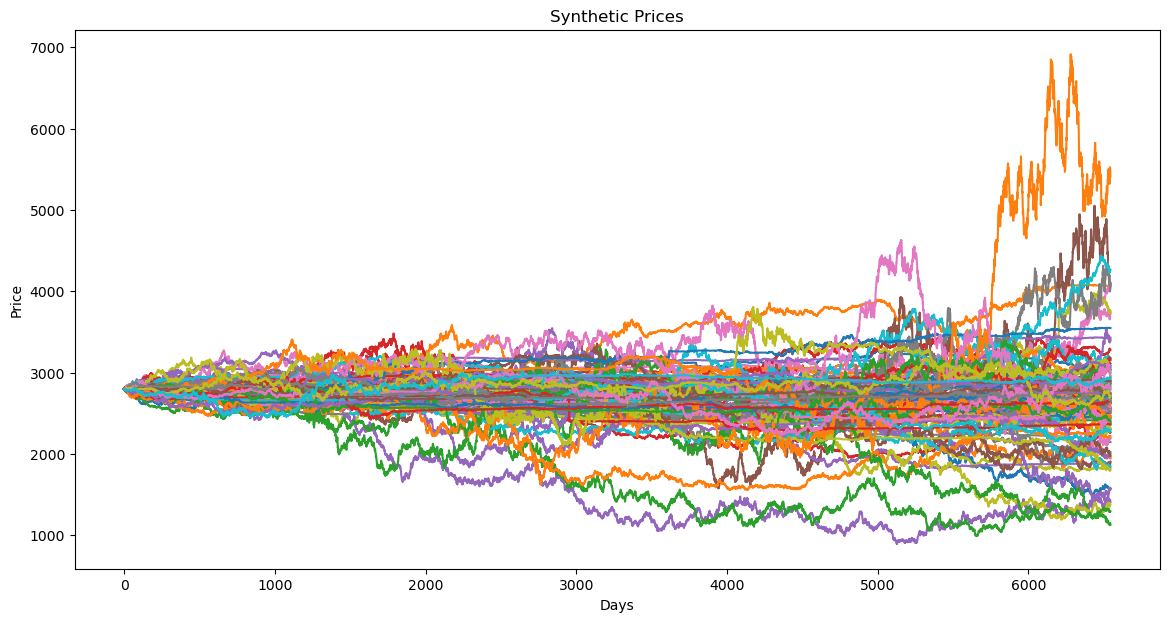

In [100]:
# plot synthetic prices 
plt.figure(figsize=(14, 7))
plt.plot(synthetic_prices)
plt.title("Synthetic Prices")
plt.xlabel("Days")
plt.ylabel("Price")
plt.show()
